# Se carga la data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
df1 = pd.read_csv('data/data_fail.csv')
df=df1.copy(deep=True)
print(df.shape)
df.head()

(5489, 91)


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_242_normalized,smart_242_raw,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw
0,2016-01-01,Z300ZST1,ST4000DM000,1.976651e-311,0,120,240872800,NaN,NaN,91,...,100.0,9.784107e-313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,9VY8TCAV,ST3160318AS,7.907120e-313,0,111,38605541,NaN,NaN,97,...,100.0,2.076417e-314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,W300BG0H,ST4000DM000,1.976651e-311,0,118,190147064,NaN,NaN,91,...,100.0,6.394443e-313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,W300J6FX,ST4000DM000,1.976651e-311,0,115,85258376,NaN,NaN,92,...,100.0,6.040397e-313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,Z3014A4S,ST4000DM000,1.976651e-311,0,116,101976792,NaN,NaN,91,...,100.0,1.019657e-312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
columnas=df.columns
columnas_raw=[]
for i in columnas:
    l=len(i)
    if i[l-3:]== 'raw':
        columnas_raw.append(i)
columnas_raw.append('smart_9_normalized')
# no eliminamos la columna smart_9_raw,
# ya que esta indica el tiempo de vida del disco
columnas_raw.remove('smart_9_raw')
df=df.rename(columns={'smart_9_raw':'time_day'})
df['time_day']=df['time_day']/24
df = df.drop(columns=columnas_raw, axis=1)


# Registros que fallaron

In [4]:
failed_hdds = df.loc[df.failure==1]["serial_number"]
failed_hdds.describe()

count          214
unique         205
top       W3006E5B
freq             2
Name: serial_number, dtype: object

In [5]:
fallas=df.loc[df.failure==1]

In [6]:
doble_falla=fallas.groupby("serial_number")['serial_number'].count().sort_values(ascending=False).head(9).index
doble_falla

Index(['Z300GQAF', 'W3006E5B', 'W300J9JA', 'Z300KHN0', 'Z3015V4D',
       'PL1311LAG2B1NH', 'Z300ZSJQ', 'Z300GYM0', 'Z3001J37'],
      dtype='object', name='serial_number')

In [7]:
registros_a_eliminar=[]
for i in doble_falla:
    aux=df['serial_number'].loc[df.serial_number==i][df.failure==1].index
    registros_a_eliminar.append(max(aux))
    print(aux)
print(registros_a_eliminar)

Int64Index([3525, 3649], dtype='int64')
Int64Index([153, 344], dtype='int64')
Int64Index([3415, 3539], dtype='int64')
Int64Index([106, 297], dtype='int64')
Int64Index([121, 312], dtype='int64')
Int64Index([3483, 3607], dtype='int64')
Int64Index([3468, 3592], dtype='int64')
Int64Index([3410, 3534], dtype='int64')
Int64Index([3453, 3577], dtype='int64')
[3649, 344, 3539, 297, 312, 3607, 3592, 3534, 3577]


In [8]:
for i in registros_a_eliminar:
    df=df.drop([i],axis=0)
failed_hdds = df.loc[df.failure==1]["serial_number"]
failed_hdds.describe()

count          205
unique         205
top       W0Q6KWV8
freq             1
Name: serial_number, dtype: object

**Eliminamos los registros repetidos de fallas**


# Creación de la columna vida_util_restante_int

Es una columna que refleja, cuantos dias de vida le quedan al producto, para que falle. Esto es con el fin de identificar cambios en las variables tipo smart.


In [9]:
#Crear una columna con el dia en que muere el articulo
df["end_date"] = df.groupby("serial_number")["date"].transform("max")

#Tiempo de Vida util articulo(Real)
df['vida_util_days'] = df.groupby("serial_number")["time_day"].transform("max")


#Transformamos a fecha
df["end_date"] = pd.to_datetime(df["end_date"])
df["date"] = pd.to_datetime(df["date"])


#Vida util que le queda al articulo
df["vida_util_restante"] = (df["end_date"] - df["date"])
#Vida util que le queda al articulo (int)
df["vida_util_restante_int"] = (df["vida_util_restante"].astype('int64')/60**2)/24/1000000000.0

#Vida util que le queda al articulo porcentual
#df["vida_util_restante_porcentual"] = (df["vida_util_restante_int"]/df["vida_util_int"])

df_unique = df[df.failure==1]



In [10]:
df["vida_util_days"].describe()

count    5480.000000
mean      864.437181
std       522.790741
min         0.583333
25%       444.291667
50%       839.166667
75%      1150.791667
max      2822.666667
Name: vida_util_days, dtype: float64

In [11]:
df["vida_util_restante"].describe()

count                          5480
mean     49 days 11:28:12.262773722
std      44 days 09:03:20.392622798
min                 0 days 00:00:00
25%                 7 days 00:00:00
50%                21 days 12:00:00
75%                95 days 00:00:00
max               119 days 00:00:00
Name: vida_util_restante, dtype: object

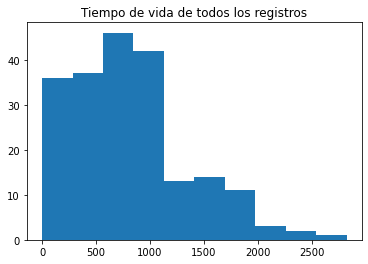

In [12]:
plt.hist(df_unique['vida_util_days'])#, bins=10
plt.title("Tiempo de vida de todos los registros", fontdict=None, loc='center', pad=None,)
plt.show()

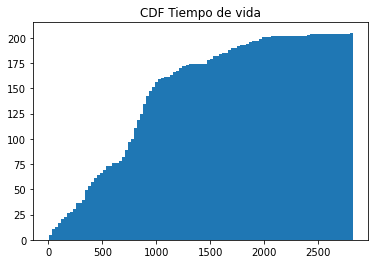

In [13]:
plt.hist(df_unique['vida_util_days'],cumulative=True ,bins=100)#, bins=10
plt.title("CDF Tiempo de vida", fontdict=None, loc='center', pad=None,)
plt.show()

## Comienzo Parte 1 b

In [14]:
df_last_weak    = df[df.vida_util_restante_int<=7]
df_last_2_weaks = df[df.vida_util_restante_int<=14]
df_last_month   = df[df.vida_util_restante_int<=30]

In [15]:
mean_weak = df_last_weak.mean()
std_weak  = df_last_weak.std()
skew_weak = df_last_weak.skew()

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [16]:
mean_2_weaks  = df_last_2_weaks.mean()
std_2_weaks   = df_last_2_weaks.std()
skew_2_weaks  = df_last_2_weaks.skew()

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [17]:
mean_month = df_last_month.mean()
std_month  = df_last_month.std()
skew_month = df_last_month.skew()

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [18]:
d = {}
A=[]
B=[]
C=[]
L=[]
M=[]
N=[]
X=[]
Y=[]
Z=[]
Indices=[]

for i in mean_month.index:
    if i[:5]=='smart':
        indice=list(mean_month.index).index(i)
        Indices.append(i)
        
        A.append(list(mean_weak.values)[indice])
        B.append(list(mean_2_weaks.values)[indice])
        C.append(list(mean_month.values)[indice])
        
        L.append(list(std_weak.values)[indice])
        M.append(list(std_2_weaks.values)[indice])
        N.append(list(std_month.values)[indice])
        
        X.append(list(skew_weak.values)[indice])
        Y.append(list(skew_2_weaks.values)[indice])
        Z.append(list(skew_month.values)[indice])
        
        
d= {'Indices':Indices,'Mean_Weak':A,'Mean_2_Weak':B,'Mean_Month':C,
    'sd_Weak':L,'sd_2_WeakS':M,'sd_Month':N,'skew_Weak':X,
    'skew_2_Weaks':Y,'skew_Month':Z}

## Agregamos el coeficiente de variación

Este valor nos indica la variación de los los valores de las variables SMART, si estas poseen un valor muy bajo de variaciones, su influencia en el modelo es despreciable. Así que eliminaremos todas aquellas que poseean un coeficiente de variación inferior al 1%.

In [19]:
stats_smart=pd.DataFrame.from_dict(d)
stats_smart["Coef_Var_Month"] = ((stats_smart['sd_Month'])/(stats_smart['Mean_Month']))

In [20]:
val_delete=stats_smart[stats_smart.Coef_Var_Month>0.1]
len(val_delete)

15

In [21]:
stats_smart = stats_smart.round(1)
columnas_weak_month = stats_smart.columns
stats_smart_sin_nan = stats_smart.dropna(subset=columnas_weak_month)
lista_smart_sin_nans=list(stats_smart_sin_nan['Indices']) 

In [22]:
for i in lista_smart_sin_nans:
    if i in Indices:
        Indices.remove(i)
for i in Indices:
    del df[i]
    del df_unique[i]

In [23]:
print(stats_smart.Coef_Var_Month.max())
print(stats_smart.Coef_Var_Month.min())

1.0
0.0


In [24]:
print(val_delete.Coef_Var_Month.max())
print(val_delete.Coef_Var_Month.min())

1.0434913066025737
0.10285934529283577


## Resultado de una data, sin variables con coeficiente de variación bajo.

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


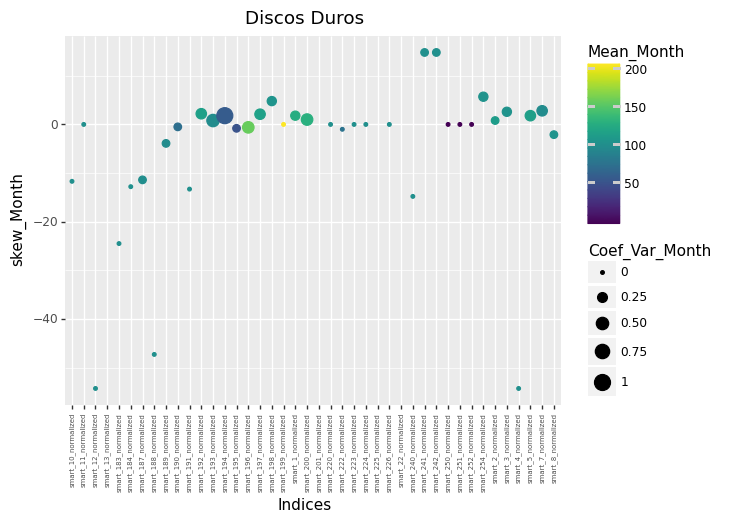

<ggplot: (347622701)>

In [25]:
ggplot(stats_smart, aes(x = "Indices", y = "skew_Month",color='Mean_Month',size='Coef_Var_Month'))\
+theme(axis_text_x=element_text(angle=90,size=5))\
+ggtitle("Discos Duros") + geom_point()


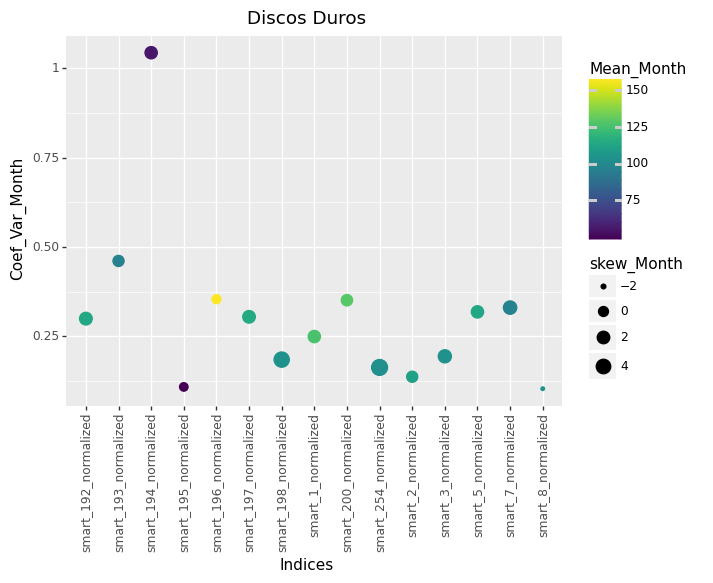

<ggplot: (347583993)>

In [26]:
ggplot(val_delete, aes(x = "Indices", y = "Coef_Var_Month",color='Mean_Month',size='skew_Month'))\
+theme(axis_text_x=element_text(angle=90))\
+ggtitle("Discos Duros") + geom_point()

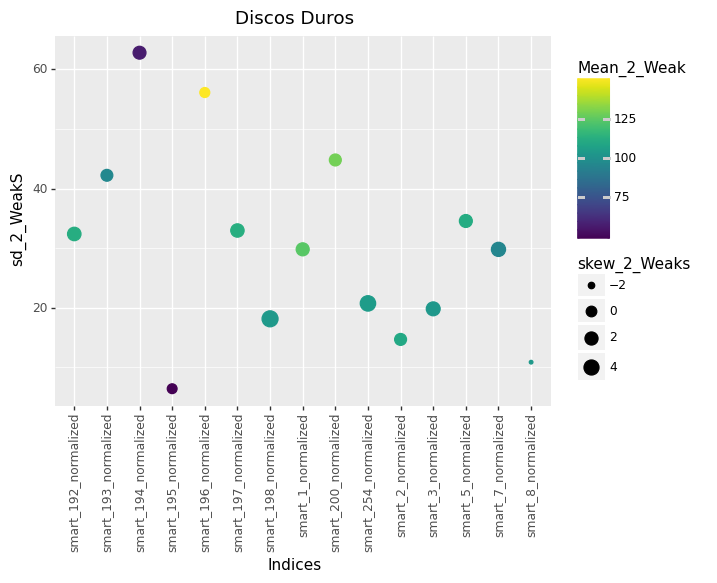

<ggplot: (346865301)>

In [27]:
ggplot(val_delete, aes(x = "Indices", y = "sd_2_WeakS",color='Mean_2_Weak',size='skew_2_Weaks'))\
+theme(axis_text_x=element_text(angle=90))\
+ggtitle("Discos Duros") + geom_point()

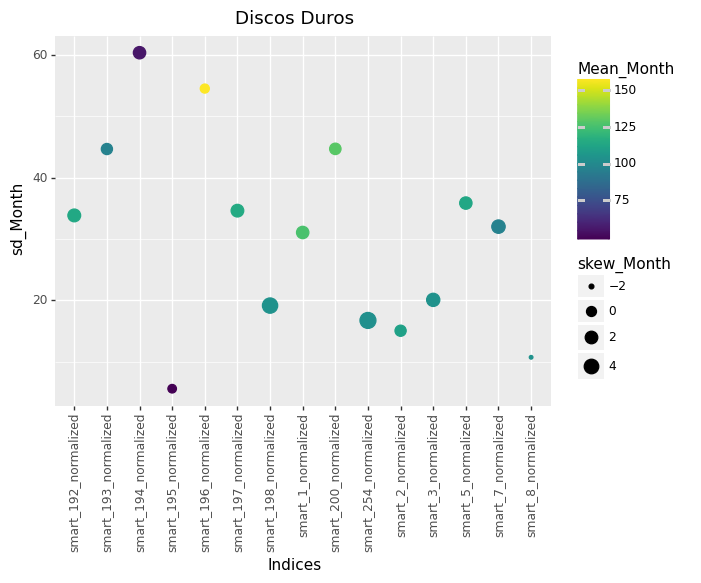

<ggplot: (347547377)>

In [28]:
ggplot(val_delete, aes(x = "Indices", y = "sd_Month",color='Mean_Month',size='skew_Month'))\
+theme(axis_text_x=element_text(angle=90))\
+ggtitle("Discos Duros") + geom_point()

Guardar el p-valor de km, donde se prioriza las variables mas significativas para explicar el comportamiento.

Separar los datos en cuartiles, como lo que se hace en edad.

# Me quedaré solo con las variables smart que poseen una covarianza superior al 10%



In [29]:
list_not_delete=val_delete.Indices

In [30]:
columnas=df.columns
columnas_coef_0_1=[]
for i in columnas:
    l=len(i)
    if i[:5]== 'smart':
        columnas_coef_0_1.append(i)
# no eliminamos la columna smart_9_raw,
# ya que esta indica el tiempo de vida del disco
for j in list_not_delete.index:
    columnas_coef_0_1.remove(list_not_delete.loc[j])
print(columnas_coef_0_1,'Cantidad de columnas a eliminar:', len(columnas_coef_0_1))

['smart_4_normalized', 'smart_10_normalized', 'smart_11_normalized', 'smart_12_normalized', 'smart_183_normalized', 'smart_184_normalized', 'smart_187_normalized', 'smart_188_normalized', 'smart_189_normalized', 'smart_190_normalized', 'smart_191_normalized', 'smart_199_normalized', 'smart_220_normalized', 'smart_222_normalized', 'smart_223_normalized', 'smart_224_normalized', 'smart_226_normalized', 'smart_240_normalized', 'smart_241_normalized', 'smart_242_normalized', 'smart_250_normalized', 'smart_251_normalized', 'smart_252_normalized'] Cantidad de columnas a eliminar: 23


In [31]:
df = df.drop(columns=columnas_coef_0_1, axis=1)

In [32]:
NANS_FINALES=df.isna().sum()>500
NANS_FINALES_index=list(NANS_FINALES.index)
NANS_FINALES_values=list(NANS_FINALES.values)
columns_to_delete=[]
for i in range(len(NANS_FINALES_index)):
    if NANS_FINALES_values[i]:
        columns_to_delete.append(NANS_FINALES_index[i])
columns_to_delete

['smart_2_normalized',
 'smart_8_normalized',
 'smart_195_normalized',
 'smart_196_normalized',
 'smart_200_normalized',
 'smart_254_normalized']

In [33]:
df = df.drop(columns=columns_to_delete, axis=1)

In [34]:
df_last_weak    = df[df.vida_util_restante_int<=7]
df_last_2_weaks = df[df.vida_util_restante_int<=14]
df_last_month   = df[df.vida_util_restante_int<=30]

mean_weak = df_last_weak.mean()
std_weak  = df_last_weak.std()
skew_weak = df_last_weak.skew()

mean_2_weaks  = df_last_2_weaks.mean()
std_2_weaks   = df_last_2_weaks.std()
skew_2_weaks  = df_last_2_weaks.skew()

mean_month = df_last_month.mean()
std_month  = df_last_month.std()
skew_month = df_last_month.skew()

d = {}
A=[]
B=[]
C=[]
L=[]
M=[]
N=[]
X=[]
Y=[]
Z=[]
Indices=[]


for i in mean_month.index:
    if i[:5]=='smart':
        indice=list(mean_month.index).index(i)
        Indices.append(i)
        
        A.append(list(mean_weak.values)[indice])
        B.append(list(mean_2_weaks.values)[indice])
        C.append(list(mean_month.values)[indice])
        
        L.append(list(std_weak.values)[indice])
        M.append(list(std_2_weaks.values)[indice])
        N.append(list(std_month.values)[indice])
        
        X.append(list(skew_weak.values)[indice])
        Y.append(list(skew_2_weaks.values)[indice])
        Z.append(list(skew_month.values)[indice])    

I=A+B+C
J=L+M+N
K=X+Y+Z
P=Indices+Indices+Indices
TIEMPO=['One weak' for i in range(len(A))]+['Two Weaks' for i in range(len(A))]+['Month' for i in range(len(A))]
d= {'Indices':Indices,'Mean_Weak':A,'Mean_2_Weak':B,'Mean_Month':C,
    'sd_Weak':L,'sd_2_WeakS':M,'sd_Month':N,'skew_Weak':X,
    'skew_2_Weaks':Y,'skew_Month':Z}
d2={'Indices':P,'Mean':I,'sd':J,'skew':K,'Periodo':TIEMPO}
df_d2=pd.DataFrame.from_dict(d2).round(1)
stats_smart=pd.DataFrame.from_dict(d)
stats_smart["Coef_Var_Month"] = ((stats_smart['sd_Month'])/(stats_smart['Mean_Month']))

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


In [35]:
stats_smart = stats_smart.round(1)

In [36]:
print(stats_smart.Coef_Var_Month.max())
print(stats_smart.Coef_Var_Month.min())

1.0
0.2


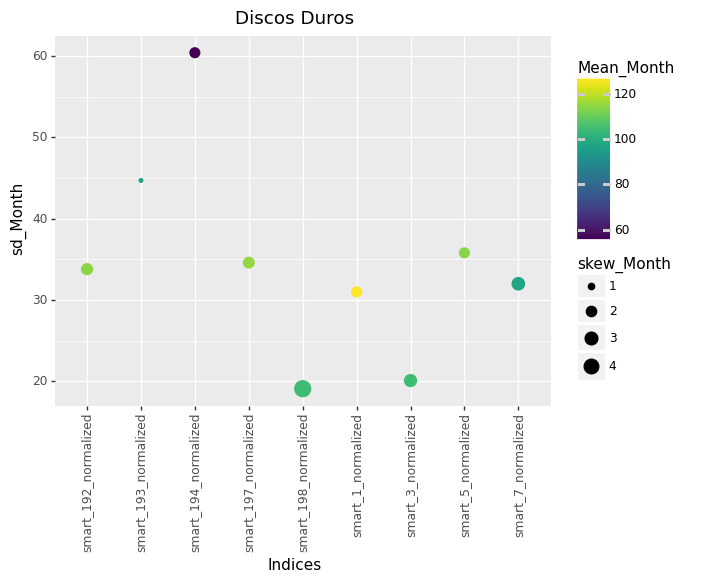

<ggplot: (348340009)>

In [39]:
ggplot(stats_smart, aes(x = "Indices", y = "sd_Month",color='Mean_Month',size='skew_Month'))\
+theme(axis_text_x=element_text(angle=90))\
+ggtitle("Discos Duros") + geom_point()

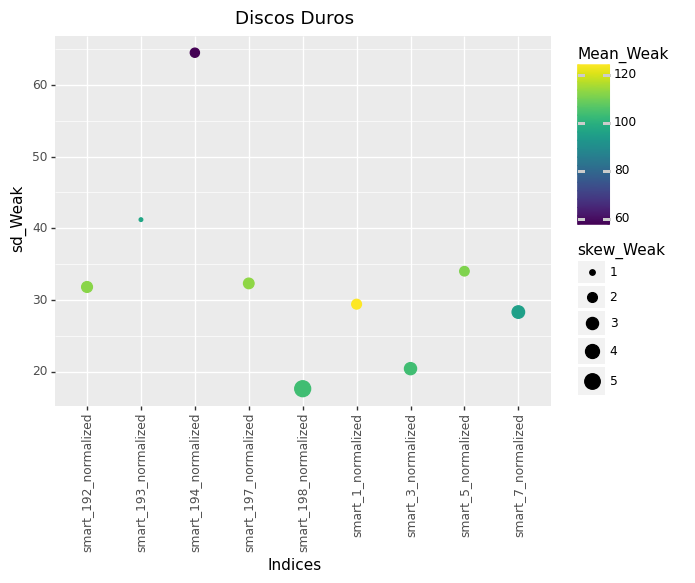

<ggplot: (348046061)>

In [40]:
ggplot(stats_smart, aes(x = "Indices", y = "sd_Weak",color='Mean_Weak',size='skew_Weak'))\
+theme(axis_text_x=element_text(angle=90))\
+ggtitle("Discos Duros") + geom_point()

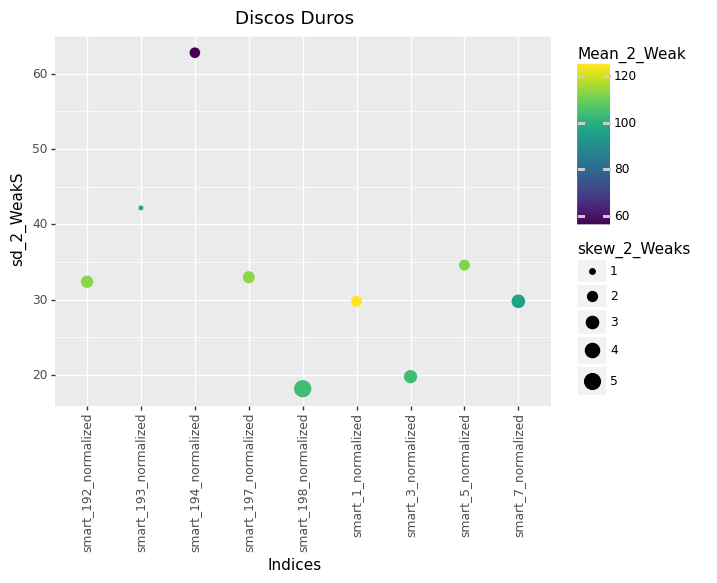

<ggplot: (348687625)>

In [41]:
ggplot(stats_smart, aes(x = "Indices", y = "sd_2_WeakS",color='Mean_2_Weak',size='skew_2_Weaks'))\
+theme(axis_text_x=element_text(angle=90))\
+ggtitle("Discos Duros") + geom_point()

In [38]:
stats_smart

,Indices,Mean_Weak,Mean_2_Weak,Mean_Month,sd_Weak,sd_2_WeakS,sd_Month,skew_Weak,skew_2_Weaks,skew_Month,Coef_Var_Month
0,smart_1_normalized,122.4,123.2,124.7,29.4,29.8,31.0,2.0,1.9,1.8,0.2
1,smart_3_normalized,103.0,103.1,103.6,20.4,19.8,20.1,3.0,2.8,2.6,0.2
2,smart_5_normalized,110.2,110.9,112.7,34.0,34.6,35.8,1.9,1.9,1.8,0.3
3,smart_7_normalized,94.9,95.7,97.0,28.3,29.8,32.0,3.2,3.0,2.8,0.3
4,smart_192_normalized,111.3,111.8,113.1,31.8,32.4,33.8,2.4,2.4,2.2,0.3
5,smart_193_normalized,96.7,96.6,96.9,41.2,42.2,44.7,0.9,0.9,0.8,0.5
6,smart_194_normalized,59.4,58.4,57.8,64.5,62.8,60.4,1.8,1.8,1.8,1.0
7,smart_197_normalized,111.6,112.2,113.8,32.3,33.0,34.6,2.3,2.3,2.1,0.3
8,smart_198_normalized,103.1,103.4,103.8,17.6,18.2,19.1,5.3,5.1,4.8,0.2


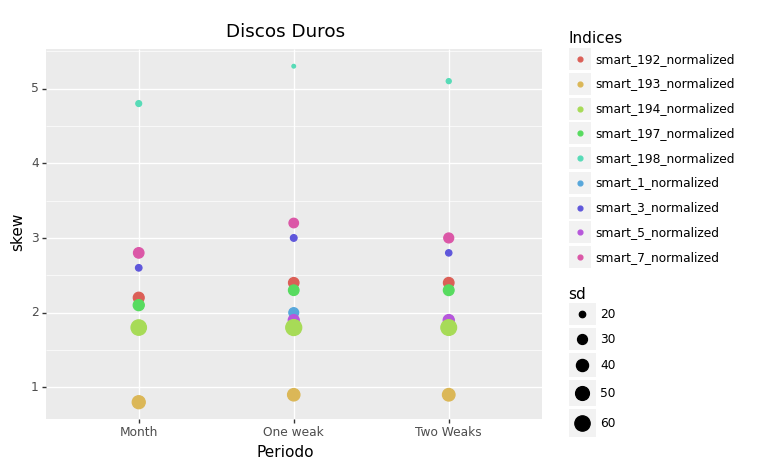

<ggplot: (338258585)>

In [89]:
ggplot(df_d2, aes(x = "Periodo", y = "skew",color='Indices',size='sd'))\
+ggtitle("Discos Duros") + geom_point()

In [ ]:
 mapping = aes(x='reorder(var2, value)', y='value')

In [46]:
df_d2

,Indices,Mean,sd,skew,Periodo
0,smart_1_normalized,122.4,29.4,2.0,One weak
1,smart_3_normalized,103.0,20.4,3.0,One weak
2,smart_5_normalized,110.2,34.0,1.9,One weak
3,smart_7_normalized,94.9,28.3,3.2,One weak
4,smart_192_normalized,111.3,31.8,2.4,One weak
5,smart_193_normalized,96.7,41.2,0.9,One weak
6,smart_194_normalized,59.4,64.5,1.8,One weak
7,smart_197_normalized,111.6,32.3,2.3,One weak
8,smart_198_normalized,103.1,17.6,5.3,One weak
9,smart_1_normalized,123.2,29.8,1.9,Two Weaks


8.0

In [96]:
df.loc[df.serial_number==lista[50]].mean().index

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


Index(['capacity_bytes', 'failure', 'smart_1_normalized', 'smart_3_normalized',
       'smart_5_normalized', 'smart_7_normalized', 'time_day',
       'smart_192_normalized', 'smart_193_normalized', 'smart_194_normalized',
       'smart_197_normalized', 'smart_198_normalized', 'vida_util_days',
       'vida_util_restante', 'vida_util_restante_int'],
      dtype='object')

In [98]:
df.loc[df.serial_number==lista[50]].mean()

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


capacity_bytes                         1.97665e-311
failure                                   0.0714286
smart_1_normalized                          114.857
smart_3_normalized                               91
smart_5_normalized                              100
smart_7_normalized                               86
time_day                                    347.101
smart_192_normalized                            100
smart_193_normalized                             99
smart_194_normalized                        22.5714
smart_197_normalized                            100
smart_198_normalized                            100
vida_util_days                                353.5
vida_util_restante        6 days 10:17:08.571428571
vida_util_restante_int                      6.42857
dtype: object

In [106]:
df.loc[df.serial_number==lista[0]].skew()

capacity_bytes           NaN
failure                  NaN
smart_1_normalized       NaN
smart_3_normalized       NaN
smart_5_normalized       NaN
smart_7_normalized       NaN
time_day                 NaN
smart_192_normalized     NaN
smart_193_normalized     NaN
smart_194_normalized     NaN
smart_197_normalized     NaN
smart_198_normalized     NaN
vida_util_days           NaN
vida_util_restante_int   NaN
dtype: float64

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


['serial_number',
 'model',
 'time_day',
 'smart_1_normalized_mean',
 'smart_3_normalized_mean',
 'smart_5_normalized_mean',
 'smart_7_normalized_mean',
 'smart_192_normalized_mean',
 'smart_193_normalized_mean',
 'smart_194_normalized_mean',
 'smart_197_normalized_mean',
 'smart_198_normalized_mean',
 'smart_1_normalized_skew',
 'smart_3_normalized_skew',
 'smart_5_normalized_skew',
 'smart_7_normalized_skew',
 'smart_192_normalized_skew',
 'smart_193_normalized_skew',
 'smart_194_normalized_skew',
 'smart_197_normalized_skew',
 'smart_198_normalized_skew']

In [ ]:
indices=+indices[2:6]+indices[7:12]

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [105]:
df_last_weak    = df[df.vida_util_restante_int<=7].copy()
df_last_2_weaks = df[df.vida_util_restante_int<=21].copy()
df_last_2_weaks = df_last_2_weaks[df_last_2_weaks.vida_util_restante_int>7]

lista=list(df.loc[df.failure==1]["serial_number"].values)
modelo=list(df.loc[df.failure==1]["model"].values)
tiempo_vida=list(df.loc[df.failure==1]["time_day"].values)

indices = list(df.loc[df.serial_number==lista[50]].mean().index)
indices = indices[2:6]+indices[7:12]
mean_indices = [i+'_mean' for i in indices]
skew_indices = [i+'_delta_skew' for i in indices]
indices = ['serial_number',"model","time_day"] + mean_indices + skew_indices

final_data = pd.DataFrame(columns=indices)

for i in range(len(lista)):
    aux=[]
    temp=[]
    aux=list(df.loc[df.serial_number==lista[i]].mean().values)
    
    aux_2=list(df_last_weak.loc[df_last_weak.serial_number==lista[i]].skew().values)
    aux_3=list(df_last_2_weaks.loc[df_last_2_weaks.serial_number==lista[i]].skew().values)
    
    delta_skew=[aux_2[i]-aux_3[i] for i in range(len(aux_2))]
    #print(aux)
    temp=[lista[i],modelo[i],tiempo_vida[i]]+aux[2:6]+aux[7:12]+delta_skew[2:6]+delta_skew[7:12]
    temp_2=temp.copy()
    #print(temp)
    df2 = pd.DataFrame([temp_2], columns=indices)
    #print(df2)
    final_data=final_data.append(df2)
final_data

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,serial_number,model,time_day,smart_1_normalized_mean,smart_3_normalized_mean,smart_5_normalized_mean,smart_7_normalized_mean,smart_192_normalized_mean,smart_193_normalized_mean,smart_194_normalized_mean,...,smart_198_normalized_mean,smart_1_normalized_delta_skew,smart_3_normalized_delta_skew,smart_5_normalized_delta_skew,smart_7_normalized_delta_skew,smart_192_normalized_delta_skew,smart_193_normalized_delta_skew,smart_194_normalized_delta_skew,smart_197_normalized_delta_skew,smart_198_normalized_delta_skew
0,WD-WCC4MKDL77ZK,WDC WD20EFRX,366.958333,200.000000,100.0,200.0,100.000000,200.000000,200.000000,120.000000,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Z300KHN0,ST4000DM000,801.916667,110.000000,91.0,100.0,85.000000,100.000000,93.000000,24.000000,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Z3015V4D,ST4000DM000,674.041667,115.000000,92.0,100.0,77.000000,100.000000,64.000000,27.000000,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,W3006E5B,ST4000DM000,872.041667,117.000000,91.0,100.0,87.000000,100.000000,63.000000,22.000000,...,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,S301146W,ST4000DM000,259.458333,113.333333,97.0,100.0,84.000000,100.000000,91.000000,21.000000,...,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,W0Q6KWV8,ST320LT007,1244.333333,114.627451,98.0,95.0,81.000000,100.000000,27.372549,25.745098,...,100.0,-0.405724,0.0,0.0,0.0,0.000000,0.000000,0.048239,0.0,0.0
0,S300XP36,ST4000DM000,348.250000,115.549020,98.0,100.0,84.000000,100.000000,82.921569,22.294118,...,100.0,-0.602388,0.0,0.0,0.0,0.000000,0.192470,0.344632,0.0,0.0
0,W300T2RC,ST4000DM000,818.875000,116.450980,91.0,100.0,89.000000,100.000000,70.509804,34.000000,...,100.0,2.192217,0.0,0.0,0.0,0.000000,0.000000,0.488901,0.0,0.0
0,Z302A13D,ST4000DM000,447.291667,114.884615,97.0,100.0,85.173077,100.000000,77.557692,19.980769,...,100.0,0.760178,0.0,0.0,0.0,0.000000,0.000000,1.719790,0.0,0.0


In [78]:
final_data = pd.DataFrame(columns=indices)
for i in lista:
    aux=[]
    temp=[]
    aux=list(df.loc[df.serial_number==i].mean().values)
    #print(aux)
    temp=[i]+aux[2:6]+aux[7:12]
    temp_2=temp.copy()
    #print(temp)
    df2 = pd.DataFrame([temp_2], columns=indices)
    #print(df2)
    final_data=final_data.append(df2)
final_data

/Users/matiaslopezportius/opt/anaconda3/envs/Machine_Learning/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.


,serial_number,smart_1_normalized,smart_3_normalized,smart_5_normalized,smart_7_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized
0,WD-WCC4MKDL77ZK,200.000000,100.0,200.0,100.000000,200.000000,200.000000,120.000000,200.0,100.0
0,Z300KHN0,110.000000,91.0,100.0,85.000000,100.000000,93.000000,24.000000,100.0,100.0
0,Z3015V4D,115.000000,92.0,100.0,77.000000,100.000000,64.000000,27.000000,100.0,100.0
0,W3006E5B,117.000000,91.0,100.0,87.000000,100.000000,63.000000,22.000000,100.0,100.0
0,S301146W,113.333333,97.0,100.0,84.000000,100.000000,91.000000,21.000000,81.0,81.0
...,...,...,...,...,...,...,...,...,...,...
0,W0Q6KWV8,114.627451,98.0,95.0,81.000000,100.000000,27.372549,25.745098,100.0,100.0
0,S300XP36,115.549020,98.0,100.0,84.000000,100.000000,82.921569,22.294118,100.0,100.0
0,W300T2RC,116.450980,91.0,100.0,89.000000,100.000000,70.509804,34.000000,100.0,100.0
0,Z302A13D,114.884615,97.0,100.0,85.173077,100.000000,77.557692,19.980769,100.0,100.0


In [107]:
final_data.to_csv("data_smart_mean_delta_skew.csv", index = False, sep=',', encoding='utf-8')

# Generar variables dummy para model 

In [ ]:
df.dtypes
df=pd.get_dummies(data, drop_first=True)
df.head()